In [19]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import os, sys
import json
from data_utils.data_utils import set_seed
set_seed(seed=42)
# compute the absolute path to your project root:
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# insert it at the front of Python’s module search path:
sys.path.insert(0, root)

In [21]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

import torch
import json
from torch.nn import functional as F
import torch.optim as optim

# Dataset wrapper
from data_utils.datasets import SASRTrainDataset

# Model and evaluation
from models.sasr import SASR
from evaluation import evaluate_ranking_model, evaluate_featureaware_model

In [22]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Running on", device)

Running on mps


In [55]:
from data_utils.preprocess import load_movielens, get_user_sequences, split_sequences
import json

def load_json_from_file(file_path):
    """
    Loads JSON data from a file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: A dictionary representing the JSON data, or None if an error occurs.
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
            return data
    except FileNotFoundError:
        print(f"Error: File not found at '{file_path}'")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in '{file_path}'")
        return None

file_path = '../data/'


ratings, users, movies = load_movielens(file_path)
user_seqs = get_user_sequences(ratings)

user_splits = split_sequences(user_seqs, train_ratio=0.8, val_ratio=0.1)

train_exs = load_json_from_file(f'{file_path}train_data.json')
val_exs = load_json_from_file(f'{file_path}val_data.json')
test_exs = load_json_from_file(f'{file_path}test_data.json')

all_movies = set(movies["MovieID"].unique())
all_users = set(users["UserID"].unique())
num_total_movies = len(all_movies)
num_total_users = len(all_users)

print(train_exs[0])


{'UserID': 0, 'prefix': [3117, 1250], 'positive': 1672, 'negatives': [2620, 456, 102, 3038, 1126], 'padded_prefix': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3117, 1250], 'mask': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]}


In [106]:
batch_size = 1024

train_ds = SASRTrainDataset(train_exs, num_negatives=1)
val_ds   = SASRTrainDataset(val_exs,   num_negatives=1)

sasr = SASR(num_total_users, num_total_movies).to(device)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)
optimizer = optim.Adam(sasr.parameters(), lr=1e-3)

def bpr_loss(sasr, encoded_seq_next, pos, neg):
    
    pos_scores = torch.sum(encoded_seq_next * sasr.item_embeddings(pos), -1)
    neg_scores = torch.sum(encoded_seq_next * sasr.item_embeddings(neg), -1)
    
    return -(pos_scores - neg_scores).sigmoid().log().mean()

Epoch 1/1 — Train: 0.4891, Val: 0.4535


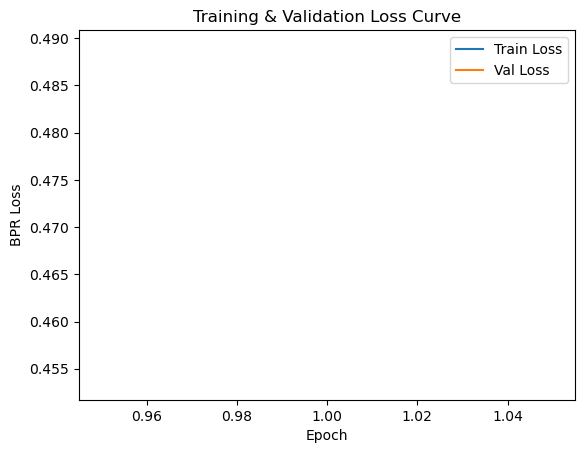

In [110]:
epochs = 1
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    # ——— train ———
    sasr.train()
    tot_train = 0.0
    for user, pos, neg, prefix in train_loader:
        user, pos, neg, prefix = (user.to(device), pos.to(device), neg.to(device), prefix.to(device))
        optimizer.zero_grad()
        encoded_seq_next = sasr(user, prefix)[:, -1, :]
        loss = bpr_loss(sasr, encoded_seq_next, pos, neg)
        loss.backward()
        optimizer.step()
        tot_train += loss.item()
    avg_train = tot_train / len(train_loader)
    train_losses.append(avg_train)

    # ——— val ———
    sasr.eval()
    tot_val = 0.0
    with torch.no_grad():
        for user, pos, neg, prefix in val_loader:
            user, pos, neg, prefix = user.to(device), pos.to(device), neg.to(device), prefix.to(device)
            encoded_seq_next = sasr(user, prefix)[:, -1, :]
            tot_val += bpr_loss(sasr, encoded_seq_next, pos, neg).item()
    avg_val = tot_val / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch}/{epochs} — Train: {avg_train:.4f}, Val: {avg_val:.4f}")

# Cell 6: plot curves
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("BPR Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

In [ ]:
metrics = evaluate_ranking_model(
    model=sasr,
    user_splits=user_splits,
    global_items=all_movies,
    device=device,
    candidate_size=100,
    k=10,
    model_type='sasr'
)

print("Evaluation Metrics:")
for name, val in metrics.items():
    print(f"- {name}: {val:.4f}")

In [155]:
toy_story_emb = sasr.item_embeddings.weight[1]               # shape: [32]
item_embs = F.normalize(sasr.item_embeddings.weight, dim=1)  # shape: [3883, 32]
toy_story_emb = toy_story_emb / toy_story_emb.norm()       # shape: [32]
similarities = item_embs @ toy_story_emb  # shape: [3883]
# Step 4: Get top-k most similar item indices (excluding itself if needed)
topk = torch.topk(similarities, k=10 + 1)

## Adding 1 here because 0 is my padding index
movie_id_to_index = {movie_id: i + 1 for i, movie_id in enumerate(movies['MovieID'].unique())}
index_to_movie_id = {v: k for k, v in movie_id_to_index.items()}

indices = topk.indices.tolist()
# # Look them up in the movies DataFrame
mapped_movies = []
for values in indices:
    mapped_movies.append(index_to_movie_id[values])
similar_movies_df = movies[movies['MovieID'].isin(mapped_movies)]
# # Optional: Sort by similarity score
scores = similarities[indices].tolist()
similar_movies_df['similarity'] = scores
similar_movies_df = similar_movies_df.sort_values(by='similarity', ascending=False)

print(similar_movies_df[['MovieID', 'Title', 'similarity']])

      MovieID                           Title  similarity
0           1                Toy Story (1995)    1.000000
281       284             New York Cop (1996)    0.459784
336       340                 War, The (1994)    0.435410
683       692                     Solo (1996)    0.422883
1575     1617        L.A. Confidential (1997)    0.414121
1864     1933  Life of Émile Zola, The (1937)    0.402022
2295     2364        Godzilla (Gojira) (1984)    0.390662
2556     2625     Black Mask (Hak hap) (1996)    0.385866
2638     2707           Arlington Road (1999)    0.372948
3078     3147          Green Mile, The (1999)    0.364207
3475     3544         Shakes the Clown (1991)    0.353726


/var/folders/bw/0d70cdj52fn0jt8hp7qxqj5r0000gn/T/ipykernel_1818/3642352183.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_movies_df['similarity'] = scores
